# NYC Public Schools SAT Scores - Any Demographic Impact ?

The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of `800` points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.  
New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test.

## Read in the data

In [19]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [20]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Base Data Cleaning

### Add DBN columns

In [21]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [22]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [23]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [24]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [25]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [26]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## First Remarks - Correlations

In [27]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plot correlations

In [28]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

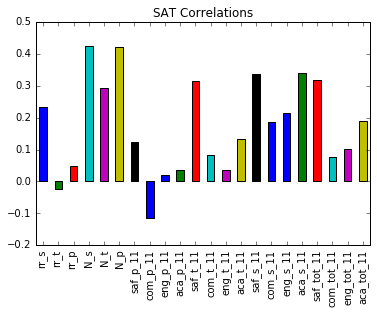

In [37]:
combined.corr()['sat_score'][survey_fields].plot.bar(title="SAT Correlations")

* There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. These columns being correlated with total_enrollment, it makes sense that they would be high.

* The percentage of students that completed the survey or *student response rate* (`rr_s`), also correlates with sat_score. This make sense as well because a student who is doing well academically will be more likely to fill out surveys.

* We can observe that `saf_t_11` and `saf_s_11` i.e. ***students*** and ***teachers*** percieved safety correlate with `sat_score`. One can indeed easily assume that it is hard to teach or learn in an unsafe environment.

* How ***students*** perceive academic standards (`aca_s_11`) is also correlated with `sat_score` but the correlation is not observed with ***parents*** or ***teachers*** perception. This could imply that (and would be logical) student feelings and experience prevails over third parties opinions over "what is best". 

## Further Into Safety 

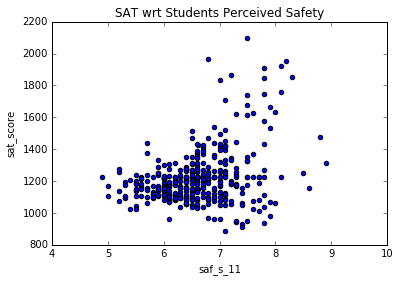

In [44]:
combined.plot(kind="scatter",x='saf_s_11',y='sat_score', title="SAT wrt Students Perceived Safety")
plt.show()

A correlation between `sat_score` and `safety` could be made out even though this correlation isn't that clear.  
However, one thing is of note, one could identify two regions of interest that would go for the positive correlation between the two variables.   
* One when `sat_score` is amongst the **lowest** and `safety`**below 6.5** : scores reach a plateau around *1500*
* The other when `sat_score` are the **highest** and `safety` **over 7** : scres are mostly over 1500

### Borough Safety Scores

In [45]:
#Group by boroughs and display safety scores
borough_saf = combined.groupby("boro").agg("mean")

In [62]:
borough_saf[['saf_s_11', 'sat_score']]

,saf_s_11,sat_score
boro,,
Bronx,6.606577,1157.598203
Brooklyn,6.370755,1181.364461
Manhattan,6.831370,1278.331410
Queens,6.721875,1286.753032
Staten Island,6.530000,1382.500000


Manhattan and Queens have got the highest safety scores where Brooklyn has the lowest **but** even if safety score seems to play a role in the final SAT score, it isn't the only parameter

## SAT & Racial Data

It could be worth a while to see the relation between `sat_score` and racial data such as the *percentage of each race at school*

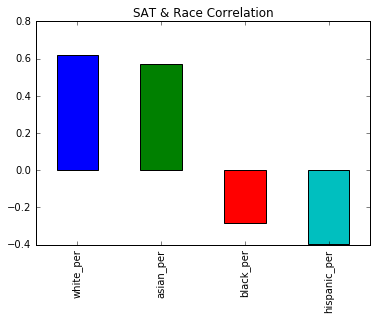

In [68]:
#racial data
race_col = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

#Plotting correlation
combined.corr()['sat_score'][race_col].plot.bar(title="SAT & Race Correlation")

A strong **positive** correlation between `sat_score` and race when students are mostly **white** or **asian** seems to exist.  
On the other hand a higher percentage of **black or hispanic** students seems to negatively correlate with sat score.  
This may be due to administrative, political and financial factors such as the *lack of funding* for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

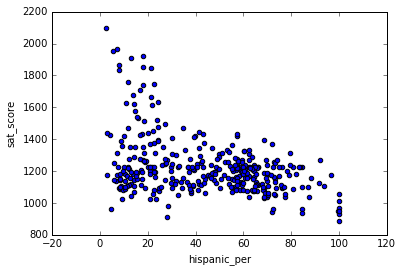

In [76]:
combined[['sat_score','hispanic_per']].plot.scatter('hispanic_per', "sat_score")

The main observation is that when the percentage of hispanic students is over *30%* `sat_score` does not go beyond *1500*.

In [81]:
#Schools with over 95% of hispanic students
combined.loc[combined['hispanic_per'] > 95, "SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Those schools appear to have their focus on recent immigrants 
to the US and so most of their students are learning English which would explain the lower SAT scores.

In [82]:
#Schools with less than 10% of hispanic students and 
#SAT score greater than 1800
combined.loc[(combined['hispanic_per'] < 10) & 
             (combined['sat_score'] > 1800), "SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of these schools seem to be specialized in science and technology. Those school receive extra funding and only admit students after they passed an entrance exam.  
This explains the higher SAT results as students come from all over NYC and do well on standardized tests. But it fails to explain the low `hispanic_per`

Race is also a factor that can explain SAT results **but** and it is important, **race itself does not explain the average SAT score** but **what race implies could** (lower family income and access to education, lack of government funding dedicated to immigrant integration and scholarisation, low English proficiency...)

## Gender Disparities

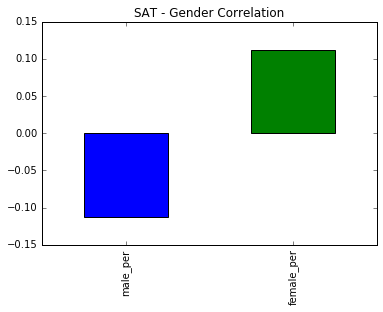

In [84]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar(title="SAT - Gender Correlation")

We can see that a high percentage of **females** at a school **positively correlates** with SAT score, whereas a high percentage of **males** at a school **negatively correlates** with SAT score. 

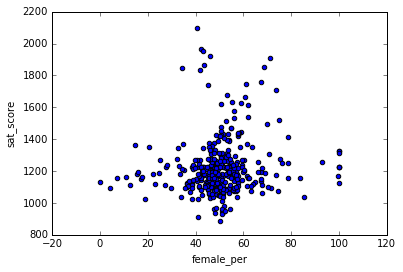

In [85]:
combined.plot.scatter("female_per", "sat_score")

It doesn't seem to be any correlation between `sat_score` and `female_per` **but** we can identify a **cluster** of schools with higher scores than the rest and those schools also have higher `female_per` (over 60%).

In [87]:
combined.loc[(combined["female_per"] > 60) & 
            (combined["sat_score"] > 1700),"SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

After reasearch it appears that these schools are very selective 
liberal arts schools that have high academic standards.

One last element that we could consider is the [Advanced Placement (AP) exams](https://en.wikipedia.org/wiki/Advanced_Placement_exams) that students can take to earn college credit.  

The number of students at a school who took AP exams should logically be highly correlated with the school's SAT scores.  
As `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. We will then look at the percentage of students in each school who took at least one AP exam.

## AP Scores & SAT Scores

In [90]:
#Calculate percentage of students in each school that took an AP exam
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

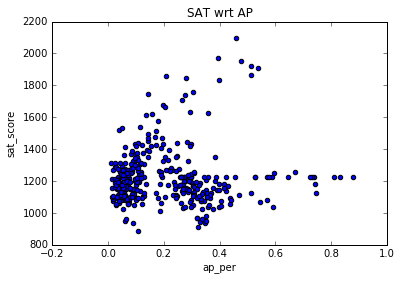

In [93]:
#See if there is a relationship between AP scors and SAT scores
combined.plot.scatter(x='ap_per', y='sat_score', title="SAT wrt AP")

The relationship between the percentage of students in a school who take the AP exam and their average SAT scores is not clear. Correlation is weak.

# Conclusions

It seems, after our primary investigations, that the **SAT** cannot be seen as an absolute indicator of level neither for the school nor the student. Indeed even though the SAT score will reflect an academic level, many other factors have to be accounted for in such an analysis.  

For example, schools admitting only the bests will tend to have the best results and the reverse is true as we saw that school which primiry objective is immigrants' English proficiency and integration will have lower SAT scores. 

SAT scores are a practical way to identify inequalities or biais and more could be done in the analysis by for example 
* Figuring out which neighborhoods have the best schools
    * If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
